In [1]:
#Load packages
import xarray as xr
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
import matplotlib.colors as colors
import pandas as pd
import cartopy.crs as ccrs
import numpy as np
import ipywidgets as widgets
from IPython.display import display
import matplotlib.patches as mpatches

In [2]:
#Load topography
continents=xr.open_dataset('/p/projects/ace/data/DeepMIP/EECO/gmd-7-2077-2014-supplement/Supp/herold_etal_eocene_topo_1x1.nc')
#continents.topo.plot(cmap='terrain',vmin=-4500,vmax=4500)
lo_masks=(continents.topo>0)

In [3]:
#840 ppm slice 
def slicesic(file,var,start,end):
    infile=file[var][::]
    startyear=infile.time[start]
    endyear=infile.time[end]
    returnfile=infile.sel(time=slice(startyear,endyear))
    return returnfile

In [4]:
def plot_fseaice(filename,filename2,title,title2):
    fig,(ax1, ax2)=plt.subplots(1,2, subplot_kw={'projection': ccrs.Robinson()},facecolor='w',figsize=(15,7))
    
    data1=filename.mean(dim='time').mean(dim='month')
    plot1=ax1.contourf(data1['lon'],data1['lat'],data1,cmap='bone_r',transform=ccrs.PlateCarree(),levels=np.linspace(0,1,11))
    lo_masks.plot.contour(ax=ax1,transform=ccrs.PlateCarree(),levels=[0.5],colors='k')
    cbar1 = plt.colorbar(plot1,ax=ax1, shrink=0.55,label='Sea Ice fraction')
    
    data2=filename2.mean(dim='time').mean(dim='month')
    plot2=ax2.contourf(data2['lon'],data2['lat'],data2,cmap='bone_r',transform=ccrs.PlateCarree(),levels=np.linspace(0,1,11))
    lo_masks.plot.contour(ax=ax2,transform=ccrs.PlateCarree(),levels=[0.5],colors='k')
    cbar2 = plt.colorbar(plot2,ax=ax2, shrink=0.55,label='Sea Ice fraction')

                         
    ax1.set(xlabel='x-label', ylabel='y-label')
    ax2.set(xlabel='x-label', ylabel='y-label')
    ax1.set_title(title)
    ax2.set_title(title2)
    
    plt.show()

In [5]:
def plot_fseaice_slider(filename, title):
    
    slider = widgets.IntSlider( min=0, max=400, step=1, description='Year:')
    output = widgets.Output()
    display(slider,output)
    timestep=(slider.value)
    
    
    def on_value_change(change):
        
        output.clear_output()
        with output:       
        
            fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.Robinson()}, facecolor='w', figsize=(7, 7))

            data = filename.mean(dim='month')[(change.new),:,:]
            plot = ax.contourf(data['lon'], data['lat'], data, cmap='bone_r', transform=ccrs.PlateCarree(), levels=np.linspace(0, 1, 11))
            lo_masks.plot.contour(ax=ax, transform=ccrs.PlateCarree(), levels=[0.5], colors='k')
            cbar = plt.colorbar(plot, ax=ax, shrink=0.55, label='Sea Ice fraction')

            ax.set(xlabel='Longitude', ylabel='Latitude')
            ax.set_title(title)

            plt.show()

    slider.observe(on_value_change, names='value')


In [6]:
def seasonal_seaice(filename,title):  
    #output = widgets.Output()
    slider_year=widgets.IntSlider(min=0,max=400,step=1,description='Timestep:')
    dropdown_month=widgets.Dropdown(options=['DJF','MAM','JJA','SON'])
    button_select=widgets.Button(description='Select')
    #input_widgets = widgets.HBox([slider_year, dropdown_month, button_select])
    #output = widgets.Output()
    #display(input_widgets,output)


    def sel_button_handler(change):
        output.clear_output()
        #with output:       
        months=[]
        if dropdown_month.value=='DJF':
            months=[12,1,2]
        elif dropdown_month.value=='MAM':
            months=[3,4,5]
        elif dropdown_month.value=='JJA':
            months=[6,7,8]
        else:
            months=[9,10,11]

        fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.Robinson()}, facecolor='w', figsize=(7, 7))

        data = filename.sel(month=months).mean(dim='month')[slider_year.value,:,:]
        plot = ax.contourf(data['lon'], data['lat'], data, cmap='bone_r', transform=ccrs.PlateCarree(), levels=np.linspace(0, 1, 11))
        lo_masks.plot.contour(ax=ax, transform=ccrs.PlateCarree(), levels=[0.5], colors='k')
        cbar = plt.colorbar(plot, ax=ax, shrink=0.55, label='Sea Ice fraction')

        ax.set(xlabel='Longitude', ylabel='Latitude')
        ax.set_title(title+' Year: '+str(slider_year.value)+'0 - '+dropdown_month.value)

        plt.show()

    button_select.on_click(sel_button_handler)

    
    input_widgets = widgets.HBox([slider_year, dropdown_month, button_select])
    output = widgets.Output()
    display(input_widgets, output)

In [7]:
def weighted_mean_sic(file):
    variable=file.mean(dim='month')
    weights=np.cos(np.deg2rad(variable.lat))
    weights.name="weights"

    k=np.zeros(400)#[]
    for t in range(0,400):
        r=(variable.isel(time=int(t)).mean(dim='lon')*weights).sum()/weights.sum()

        k[t]=r
        
    return k

In [8]:
#Monthly Sea Ice 
def monthlyseaice(filename,monthvalue):
    fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.Robinson()}, facecolor='w', figsize=(7, 7))

    data = filename.sel(month=[monthvalue]).mean(dim='month').mean(dim='time')
    plot = ax.contourf(data['lon'], data['lat'], data, cmap='bone_r', transform=ccrs.PlateCarree(), levels=np.linspace(0, 1, 11))
    lo_masks.plot.contour(ax=ax, transform=ccrs.PlateCarree(), levels=[0.5], colors='k')
    cbar = plt.colorbar(plot, ax=ax, shrink=0.55, label='Sea Ice fraction')

    ax.set(xlabel='Longitude', ylabel='Latitude')
    ax.set_title('Mean Monthly Sea Ice -'+str(monthvalue))

    plt.show()

In [9]:
Path='/p/projects/ace/petri/climber-x-eocene/55Ma_'
sic_cx_280=xr.open_mfdataset([Path+'0280ppm_eq/0002000.sic.nc',Path+'0280ppm_eq/0003000.sic.nc',Path+'0280ppm_eq/0004000.sic.nc'])
sic_cx_560=xr.open_mfdataset([Path+'0560ppm_eq/0002000.sic.nc',Path+'0560ppm_eq/0003000.sic.nc',Path+'0560ppm_eq/0004000.sic.nc'])
sic_cx_840=xr.open_mfdataset([Path+'0840ppm_eq/0002000.sic.nc',Path+'0840ppm_eq/0003000.sic.nc',Path+'0840ppm_eq/0004000.sic.nc'])
sic_cx_1120=xr.open_mfdataset([Path+'1120ppm_eq/0002000.sic.nc',Path+'1120ppm_eq/0003000.sic.nc',Path+'1120ppm_eq/0004000.sic.nc'])
sic_cx_1680=xr.open_mfdataset([Path+'1680ppm_eq/0002000.sic.nc',Path+'1680ppm_eq/0003000.sic.nc',Path+'1680ppm_eq/0004000.sic.nc'])
sic_cx_3360=xr.open_mfdataset([Path+'3360ppm_eq/0002000.sic.nc',Path+'3360ppm_eq/0003000.sic.nc',Path+'3360ppm_eq/0004000.sic.nc'])

In [10]:
#area weighted 
sicweighted_280=weighted_mean_sic(sic_cx_280.fsic)
sicweighted_560=weighted_mean_sic(sic_cx_560.fsic)
sicweighted_840=weighted_mean_sic(sic_cx_840.fsic)
sicweighted_1120=weighted_mean_sic(sic_cx_1120.fsic)
sicweighted_1680=weighted_mean_sic(sic_cx_1680.fsic)
sicweighted_3360=weighted_mean_sic(sic_cx_3360.fsic)

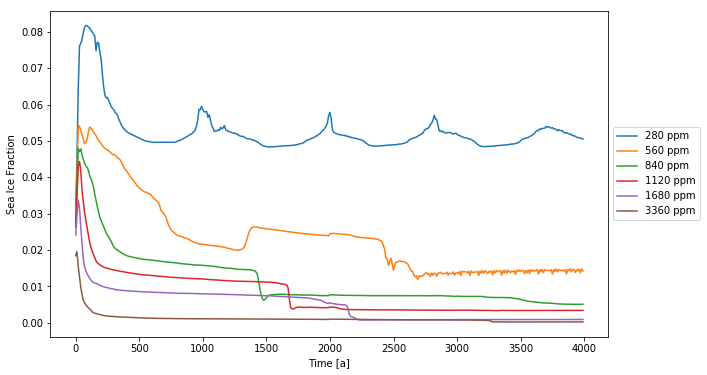

In [11]:
time=np.arange(0,4000,10)

plt.figure(figsize=(10,6))
plt.plot(time,sicweighted_280,label='280 ppm')
plt.plot(time,sicweighted_560,label='560 ppm')
plt.plot(time,sicweighted_840,label='840 ppm')
plt.plot(time,sicweighted_1120,label='1120 ppm')
plt.plot(time,sicweighted_1680,label='1680 ppm')
plt.plot(time,sicweighted_3360,label='3360 ppm')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Time [a]')
plt.ylabel('Sea Ice Fraction')
plt.show()

/p/system/packages/anaconda/5.0.0_py3/envs/idp/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


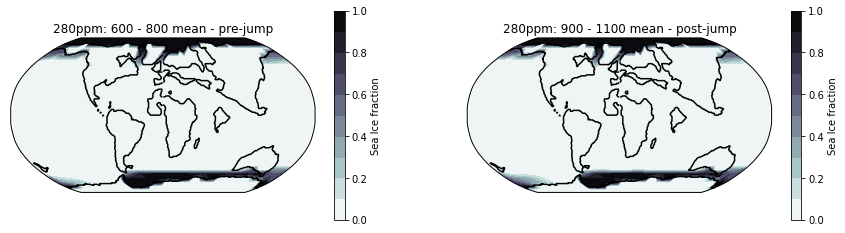

In [12]:
prejump_280=slicesic(sic_cx_280,'fsic',59,89)
postjump_280=slicesic(sic_cx_280,'fsic',89,-119)
plot_fseaice(prejump_280,postjump_280,'280ppm: 600 - 800 mean - pre-jump','280ppm: 900 - 1100 mean - post-jump')

In [13]:
plot_fseaice_slider(sic_cx_560.fsic,'')

A Jupyter Widget

A Jupyter Widget

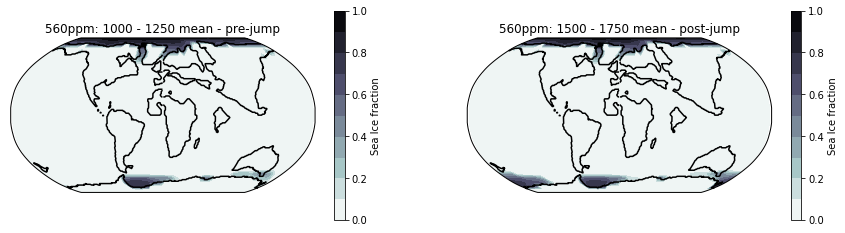

In [14]:
prejump_560=slicesic(sic_cx_560,'fsic',99,124)
postjump_560=slicesic(sic_cx_560,'fsic',149,174)
plot_fseaice(prejump_560,postjump_560,'560ppm: 1000 - 1250 mean - pre-jump','560ppm: 1500 - 1750 mean - post-jump')

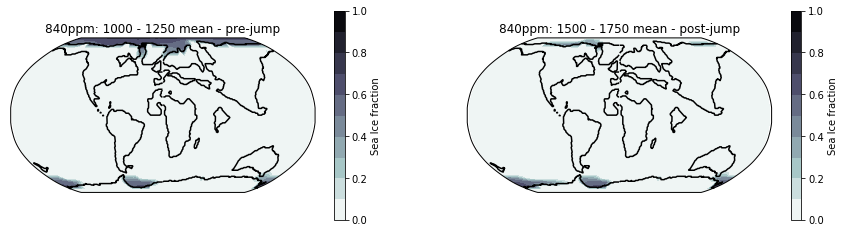

In [15]:
prejump_840=slicesic(sic_cx_840,'fsic',99,124)
postjump_840=slicesic(sic_cx_840,'fsic',149,174)
plot_fseaice(prejump_840,postjump_840,'840ppm: 1000 - 1250 mean - pre-jump','840ppm: 1500 - 1750 mean - post-jump')

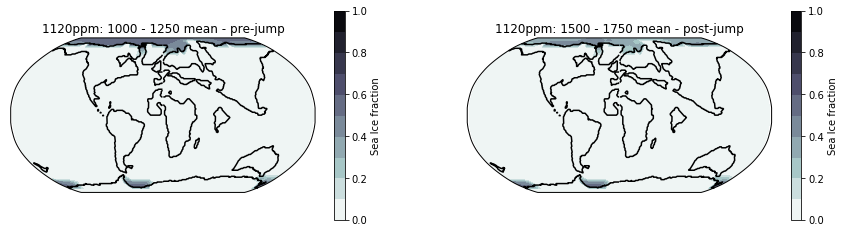

In [16]:
prejump_1120=slicesic(sic_cx_1120,'fsic',99,124)
postjump_1120=slicesic(sic_cx_1120,'fsic',149,174)
plot_fseaice(prejump_1120,postjump_1120,'1120ppm: 1000 - 1250 mean - pre-jump','1120ppm: 1500 - 1750 mean - post-jump')

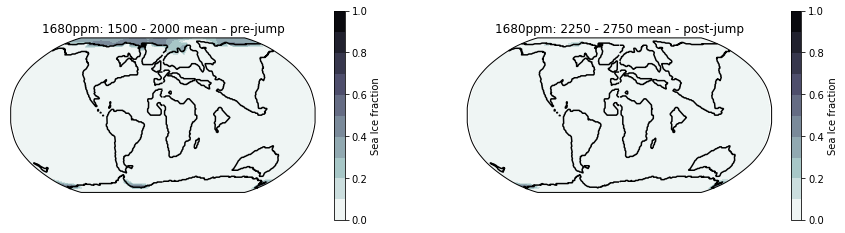

In [17]:
prejump_1680=slicesic(sic_cx_1680,'fsic',150,200)
postjump_1680=slicesic(sic_cx_1680,'fsic',225,275)
plot_fseaice(prejump_1680,postjump_1680,'1680ppm: 1500 - 2000 mean - pre-jump','1680ppm: 2250 - 2750 mean - post-jump')

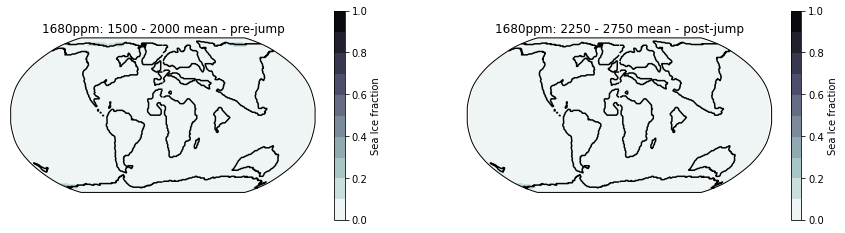

In [18]:
prejump_3360=slicesic(sic_cx_3360,'fsic',280,320)
postjump_3360=slicesic(sic_cx_3360,'fsic',330,380)
plot_fseaice(prejump_3360,postjump_3360,'1680ppm: 1500 - 2000 mean - pre-jump','1680ppm: 2250 - 2750 mean - post-jump')

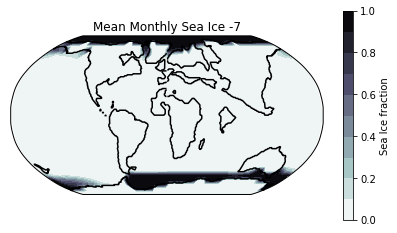

In [19]:
monthlyseaice(sic_cx_280.fsic,7)

A Jupyter Widget

A Jupyter Widget

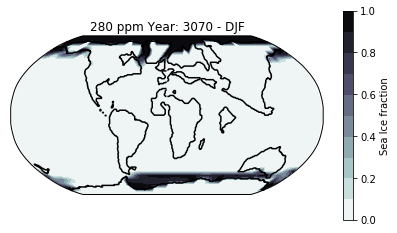

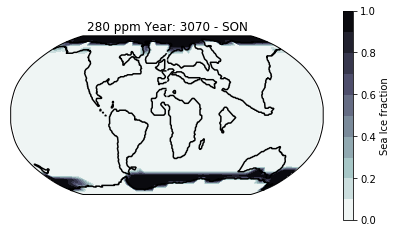

In [24]:
seasonal_seaice(sic_cx_280.fsic,'280 ppm')

In [25]:
seasonal_seaice(sic_cx_560.fsic,'560 ppm')

A Jupyter Widget

A Jupyter Widget

In [22]:
seasonal_seaice(sic_cx_560.fsic,'560 ppm')

A Jupyter Widget

A Jupyter Widget

In [23]:
seasonal_seaice(sic_cx_560.fsic,'560 ppm')

A Jupyter Widget

A Jupyter Widget